# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path
os.chdir(Path(os.path.abspath("")).parent)
from mros_data.datamodule import SleepEventDataModule

# Datamodule

The `SleepEventDataModule` class contains logic to iterate over event data by wrapping a `SleepEventDataset` class.
The datamodule is also responsible for splitting the data into train/eval partitions using the `setup()` method, and the user can then get a PyTorch `DataLoader` for each partition from the respective `*_dataloader()` methods.

## Instantiate class

We pass a dictionary of parameters to the datamodule class in order to instantiate it.
The only event-specific parameters of note are `events`, `default_event_window_duration`, `fs`, and `picks`, corresponding to the event code/event name, duration of default events, sampling frequency, and the specific channels to include.

Any transformations of the input data, such as short-time Fourier or continuous wavelet transforms can be included by the `transform` parameter.

In [4]:
from mros_data.datamodule.transforms import STFTTransform, morlet_transform, multitaper_transform
params = dict(
    data_dir="data/processed/mros/ar",
    batch_size=16,
    n_eval=2,
    n_test=2,
    num_workers=0,
    seed=1337,
    events={"ar": "Arousal"},
    window_duration=600,  # seconds
    cache_data=True,
    default_event_window_duration=[15],
    event_buffer_duration=3,
    factor_overlap=2,
    fs=128,
    matching_overlap=0.5,
    n_jobs=-1,
    n_records=10,
    picks=["c3", "c4", "eogl", 'eogr', 'chin'],
    #transform = None,
    #transform = morlet_transform.MorletTransform(fs=128, fmin=0.5, fmax=35.0, nfft=1024),
    transform=STFTTransform(fs=128, segment_size=int(4.0 * 128), step_size=int(0.125 * 128), nfft=1024, normalize=True),
    #transform = multitaper_transform.MultitaperTransform(fs=128, fmin=0.5, fmax=35, tw=8.0, normalize=True),
    scaling="robust",
)

dm = SleepEventDataModule(**params)
print(dm)

SleepEventDataModule(data_dir=WindowsPath('C:/Users/nulle/Documents/School_Work_DTU/Semester6/02526_Mathmod/sleep-project_grp4/data/processed/mros/ar'), n_test=2, n_eval=2, seed=1337, events={'ar': 'Arousal'}, window_duration=600, cache_data=True, default_event_window_duration=[15], event_buffer_duration=3, factor_overlap=2, fs=128, matching_overlap=0.5, n_jobs=-1, n_records=10, picks=['c3', 'c4', 'eogl', 'eogr', 'chin'], transform=<mros_data.datamodule.transforms.stft_transform.STFTTransform object at 0x00000238CF19D570>, scaling='robust', batch_size=16, num_workers=0)


## Split dataset into train/eval partitions

In [5]:
from tqdm import tqdm
# The datamodule will split the dataset into train/eval partitions by calling the setup() method.
dm.setup('fit')
train_dl, eval_dl = dm.train_dataloader(), dm.val_dataloader()

# The dataloaders are generators, ie. we can iterate over them using a for-loop.
for i, (data, events, records, *_) in enumerate(train_dl):
    #print(events)
    print(data.shape)
    #print(len(records))
    print(records)
    if i < 1:
        print(f'Batch size: {data.shape[0]} | No. channels: {data.shape[1]} | No. timepoints {data.shape[2]} | No. events: {sum([ev.shape[0] for ev in events])} | Data sample size: {list(data.shape[1:])} ')
    #(data.shape)
    break



Using cache for data prep: C:\Users\nulle\Documents\School_Work_DTU\Semester6\02526_Mathmod\sleep-project_grp4\data\.cache


 ... (more hidden) ...


Using cache for data prep: C:\Users\nulle\Documents\School_Work_DTU\Semester6\02526_Mathmod\sleep-project_grp4\data\.cache


 ... (more hidden) ...


torch.Size([16, 5, 513, 4801])
['mros-visit1-aa0003', 'mros-visit1-aa0005', 'mros-visit1-aa0014', 'mros-visit1-aa0005', 'mros-visit1-aa0009', 'mros-visit1-aa0005', 'mros-visit1-aa0014', 'mros-visit1-aa0005', 'mros-visit1-aa0009', 'mros-visit1-aa0009', 'mros-visit1-aa0005', 'mros-visit1-aa0003', 'mros-visit1-aa0014', 'mros-visit1-aa0005', 'mros-visit1-aa0005', 'mros-visit1-aa0012']
Batch size: 16 | No. channels: 5 | No. timepoints 513 | No. events: 22 | Data sample size: [5, 513, 4801] 


## Access the underlying datasets

The underlying data windows can be accessed by indexing into the dataset. This will call the `__getitem__()` method and yield the signals, and associated events. 
The events' start times and durations are normalized to the window, ie. an event with elements (0.1, 0.025) in a 10 min window will start at 10 min x 60 s / min x 0.1 = 60 s , and will last 10 min x 60 s / min x 0.025 = 15 s.

In [7]:
import numpy as np
train_ds = dm.train
print(len(train_ds))
print(train_ds[0]['signal'].shape)
for idx, batch in enumerate(tqdm(train_ds)):
    #print(batch['events'])
    record = batch['record']
    data = batch['signal']
    events = batch['events']
    if not np.all(events[:,-1] == 1.0):
        print("There was a non-arousal event")
        break
        
print(batch.keys())
print(f'Record: {record} | No. channels: {data.shape[1]} | No. timepoints: {data.shape[2]} | No. events: {len(events)}')

700
(5, 513, 4801)


 ... (more hidden) ...

dict_keys(['signal', 'events', 'stages', 'record', 'localizations_target', 'classifications_target'])
Record: mros-visit1-aa0014 | No. channels: 513 | No. timepoints: 4801 | No. events: 0


## Plotting signals

We can plot signals in the underlying dataset by using the `plot_signals()` method in the `SleepEventDataset`. Simply provide an index in the range `[0, len(dataset)]` and optionally a list of the applied channels:

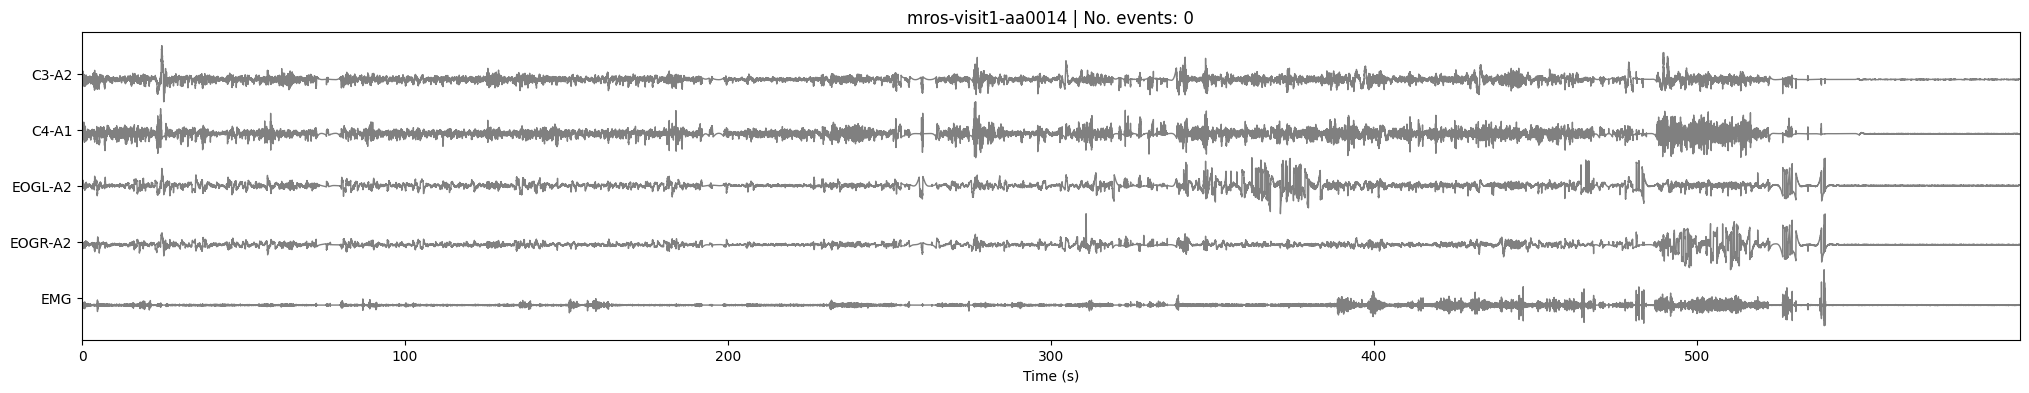

In [8]:
train_ds.plot_signals(idx, channel_names=['C3-A2', 'C4-A1', 'EOGL-A2', 'EOGR-A2', 'EMG']) #['Leg L', "Leg R"])

## Transforming data on the fly

By using the `transform` argument in the `SleepEventDataModule`, we can get spectrograms of the data as well.

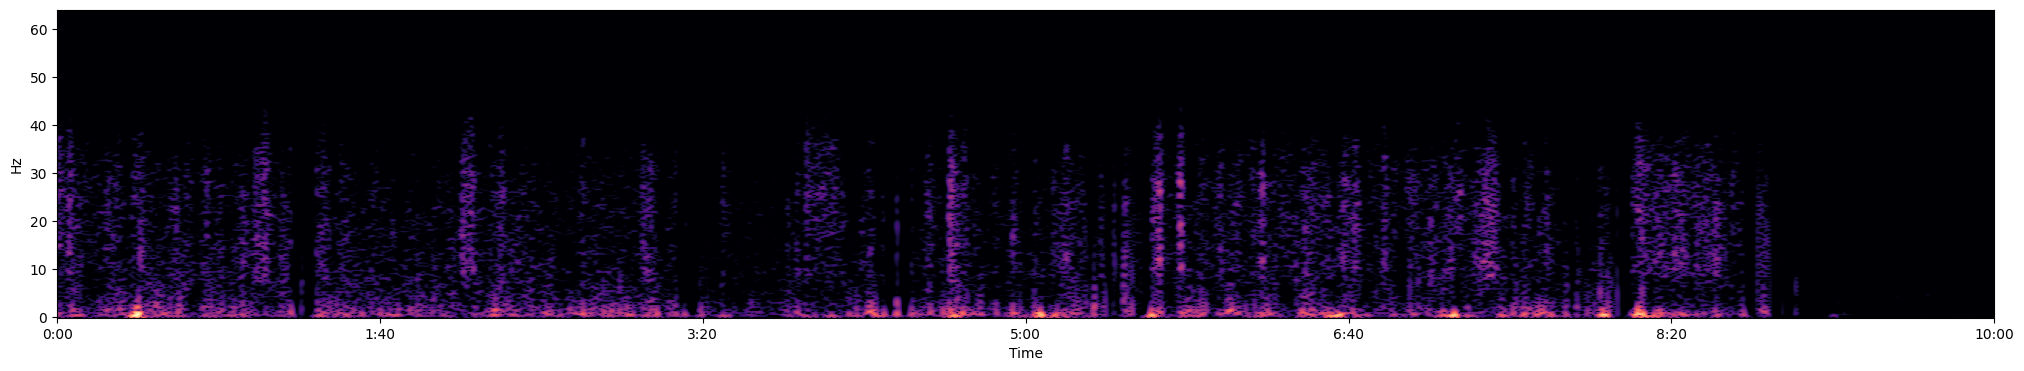

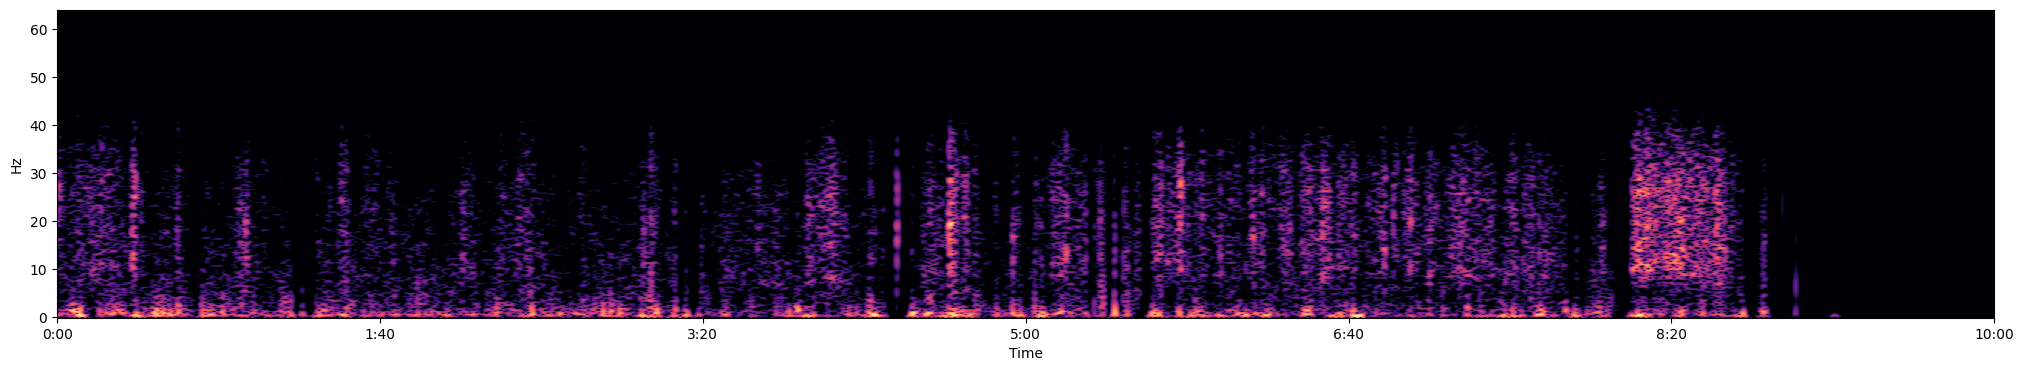

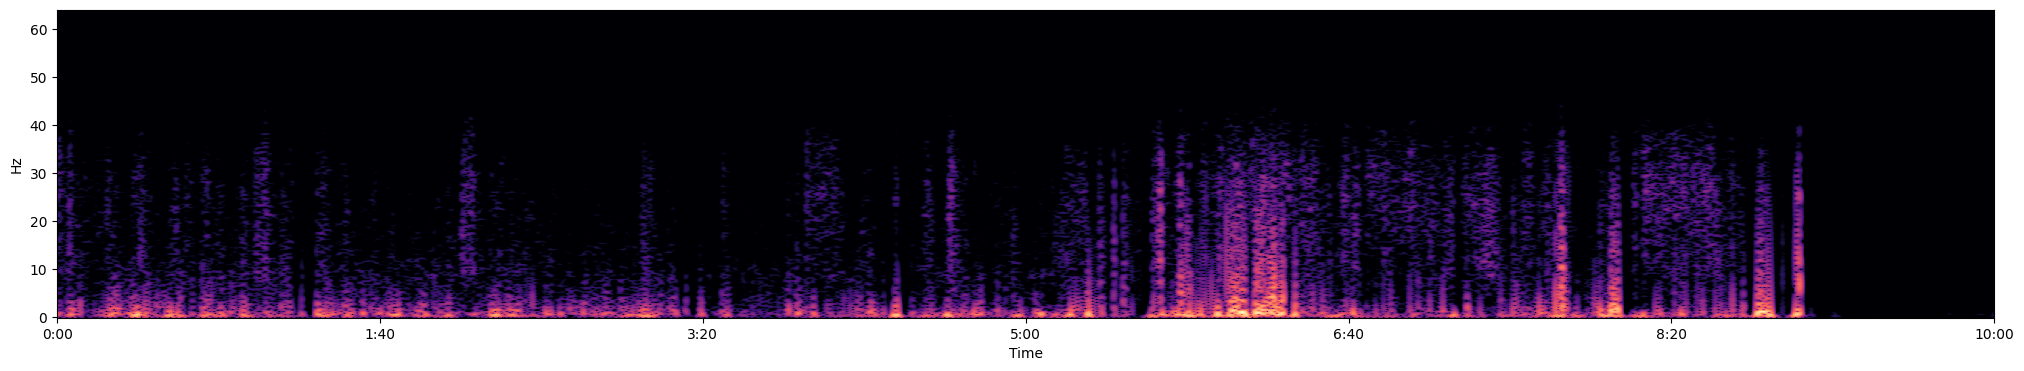

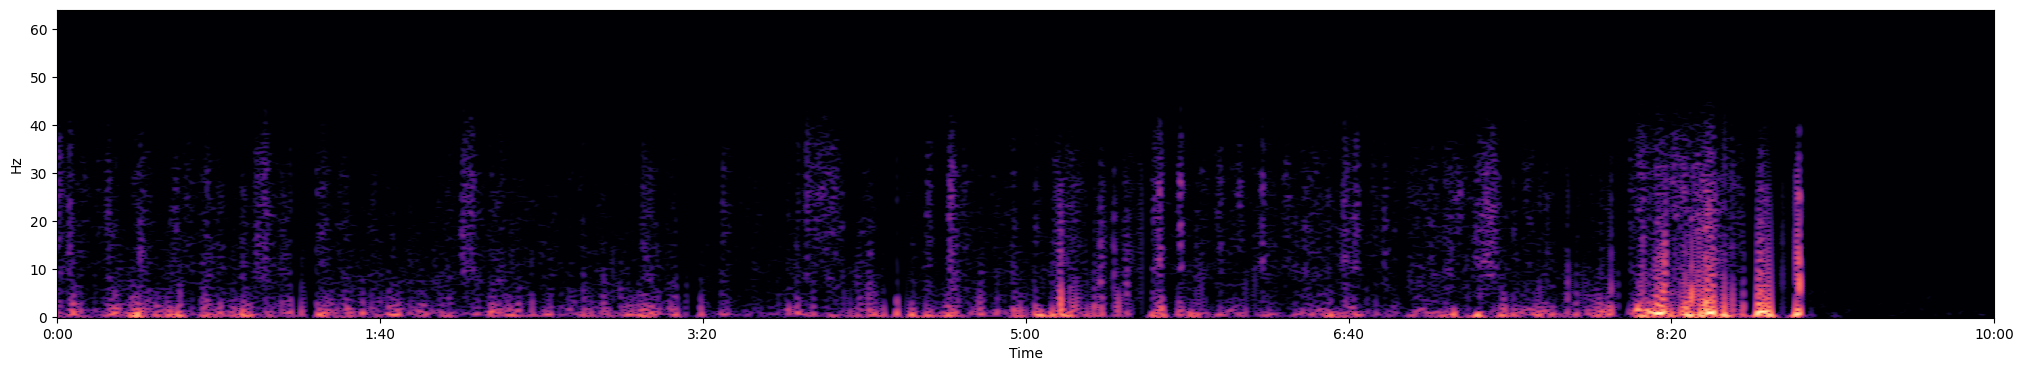

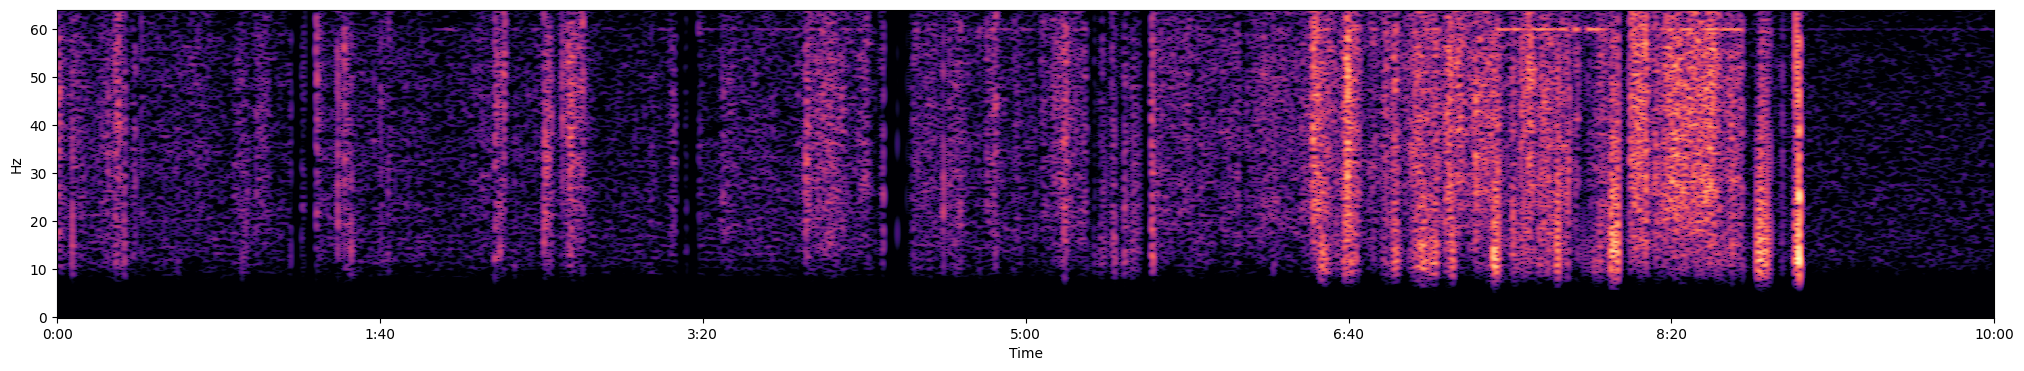

In [9]:
for channel_idx in range(5):
    train_ds.plot_spect(idx, channel_idx=channel_idx, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

We can also combine the plots by using the `plot()` method:

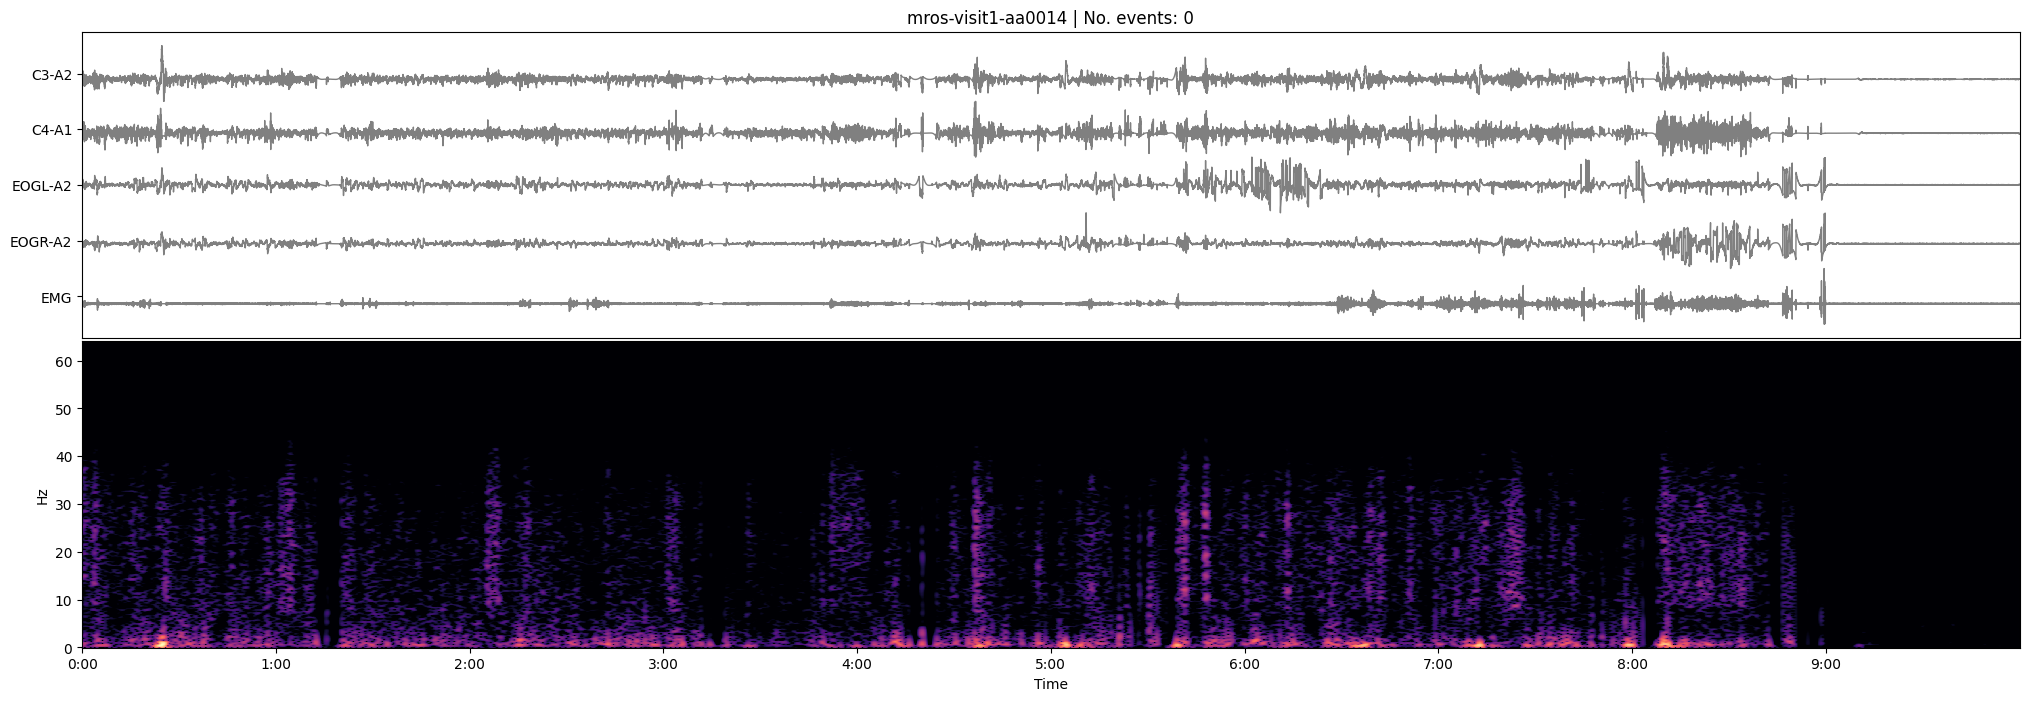

In [10]:
#%matplotlib widget
train_ds.plot(idx, channel_names=['C3-A2', 'C4-A1', 'EOGL-A2', 'EOGR-A2', 'EMG'], channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

## Experimentation

In [11]:
for idx, batch in enumerate(train_ds):
    record = batch['record']
    data = batch['signal']
    events = batch['events']
    if len(events) > 5:
        break

In [12]:
np.all(events[:,-1] == 1.0)

True